In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 28.77 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=af8864000772eda67967eb6bf5b9aee2a56cd2653bc90f46589eee90f1c0e0c7
  Stored in directory: /tmp/pip-ephem-wheel-cache-xpj1476z/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [0]:
from deepul.hw1_helper import *

Dataset 1


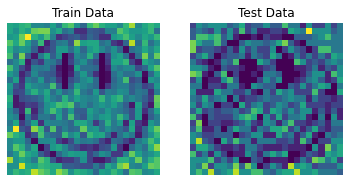

Dataset 2


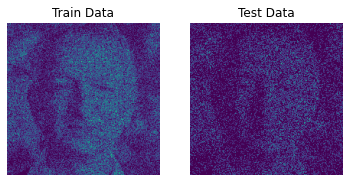

In [3]:
visualize_q2a_data(dset_type=1)
visualize_q2a_data(dset_type=2)

In [0]:

import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [0]:
def ohe(x, d):
  # assuming x is a flattened tensor and d is the number of distinct value for each element in x
  ret = torch.zeros(x.shape[0], d).float().cuda()
  # dim, index, src
  ret.scatter_(1, x.unsqueeze(1), 1)
  return ret

In [0]:
class MaskedLinear(nn.Linear):
  def __init__(self, n_in, n_out, bias=True):
    super().__init__(n_in, n_out, bias)
    # stored in state_dict but not trained by optimizer
    self.register_buffer('mask', torch.ones(n_out, n_in))

  def set_mask(self, mask):
    self.mask.data.copy_(torch.from_numpy(mask))
  
  def forward(self, x):
    # A: out by in 
    # x.AT
    return F.linear(x, self.mask * self.weight, self.bias)


class MADE(nn.Module):

  def __init__(self, input_shape, d, hidden_states, ordering=None, ohe=True):
    super().__init__()
    self.d = d
    self.input_shape = input_shape
    self.n_in = np.prod(input_shape)
    self.n_out = self.n_in * d
    self.hidden_states = hidden_states
    if ordering is None:
      self.ordering = np.arange(self.n_in)
    else:
      self.ordering = ordering
    
    self.ohe = ohe
    self.net = []
    layer_size = [self.n_in * self.d if self.ohe else self.n_in] + hidden_states + [self.n_out]
    for x,y in zip(layer_size[:-1], layer_size[1:]):
      print(x,y)
      self.net.extend([MaskedLinear(x, y), nn.ReLU()])
    self.net.pop()
    self.net = nn.Sequential(*self.net)
    self.m = {}
    self.create_masks()
  
  def create_masks(self):

    L = len(self.hidden_states)
    # according to the paper, record ordering as m0
    self.m[0] = self.ordering
    # for l =1 ... L
    for l in range(1, (L+1)):
      self.m[l] = np.random.randint(self.m[l-1].min(), self.n_in - 1, size=self.hidden_states[l-1])
    # calculate Mk1 to MkL so that mk2>=mk1 are connected
    masks = []
    for l in range(1, (L+1)):
      masks.append(self.m[l].reshape(-1,1) >= self.m[l - 1].reshape(1, -1))
    # calculate the last M so that m0>mL are connected
    masks.append(self.m[0].reshape(-1,1) > self.m[L].reshape(1, -1))

    # since the output is d * n_in long, need to fix the shape of the last mask
    masks[-1] = np.repeat(masks[-1], self.d, axis=0)
    # also, if the input is one hot encoded, mask shape should be l1, (n_in *d)
    if self.ohe:
      masks[0] = np.repeat(masks[0], self.d, axis=1)

    # assign masks to each masked layer
    layers = [l for l in self.net.modules() if isinstance(l, MaskedLinear)]
    for l, m in zip(layers, masks):
      print(m.shape)
      l.set_mask(m)

  def loss(self, x):
    """
    there is one label for each pixel, which means there is #pixel number of P
    what cross entropy does is avg all these p(reduction default to mean)
    it seems contradictory to the fact that chain rule requires the sum of these log conditional prob
    however, since the loss is nats per dim, thus we need to divide by the number of pixels
    which is exactly what this function gives
    also target needs to be long
    """
    return F.cross_entropy(self(x), x.long())
  
  def forward(self, x):
    # expects batch size, *self.input shape
    x = x.cuda()
    batch_size = x.shape[0]
    if self.ohe:
      x = x.contiguous().long().view(-1)
      x = ohe(x, self.d)
      x = x.view(batch_size, -1)
    else:
      x = x.float().view(batch_size, self.n_in)
    logits = self.net(x).view(batch_size, self.n_in, self.d)
    # return shape batch size, n class, k1,k2,... from the cross entropy doc
    return logits.permute(0, 2, 1).contiguous().view(batch_size, self.d, *self.input_shape)

  def sample(self, n):
    sample = torch.zeros(n, self.n_in).cuda()
    with torch.no_grad():
      for i in range(self.n_in):
        logits = self(sample).view(n, self.d, self.n_in)[:, :, self.ordering[i]]
        softmax_out = F.softmax(logits, dim=1)
        sample[:, self.ordering[i]] = torch.multinomial(softmax_out, 1).squeeze(-1)
      sample = sample.view(n, *self.input_shape)
    return sample.cpu().numpy()


  def get_distribution(self):
    if self.n_in != 2:
      return None
    with torch.no_grad():
      grid = np.mgrid[0:self.d, 0:self.d].reshape(2,self.d * self.d).T
      x = torch.LongTensor(grid).cuda()
      logits = self(x)
      prob = F.log_softmax(logits, dim=1)
      #input, dim, index
      distribution = torch.gather(prob, 1, x.unsqueeze(1)).squeeze(1)
      distribution = distribution.sum(dim=1) # does not seem to have a prod per row operator
    return distribution.exp().view(self.d, self.d).detach().cpu().numpy()
    

  

In [0]:
def train(model, train_loader, test_loader, param):
  n_epochs = param['epochs']
  lr = param['lr']
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  t = []
  e = [eval_loss(model, test_loader, optimizer)]
  for i in range(n_epochs):
    train_loss_ = train_loss(model, train_loader, optimizer)
    t.extend(train_loss_)
    eval_loss_ = eval_loss(model, test_loader, optimizer)
    e.append(eval_loss_)
  return t, e


In [0]:
def train_loss(model, train_loader, optimizer):
  model.train()
  loss = []
  for x in train_loader:
    x = x.cuda().contiguous()
    l = model.loss(x)
    loss.append(l.item())
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
  return loss


def eval_loss(model, test_loader, optimizer):
  model.eval()
  loss = 0
  for x in test_loader:
    x = x.cuda().contiguous()
    l = model.loss(x)
    loss += l * x.shape[0]

  return (loss/len(test_loader.dataset)).item()

In [0]:
def q2_a(train_data, test_data, d, dset_id):
  """
  train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
  test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
  d: The number of possible discrete values for each random variable x1 and x2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (d, d) of probabilities (the learned joint distribution)
  """
  
  model = MADE((2,), d, [64, 64], ohe=True).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))
  distribution = model.get_distribution()

  return train_losses, test_losses, distribution

50 64
64 64
64 50
(64, 50)
(64, 64)
(50, 64)
Final Test Loss: 3.1852


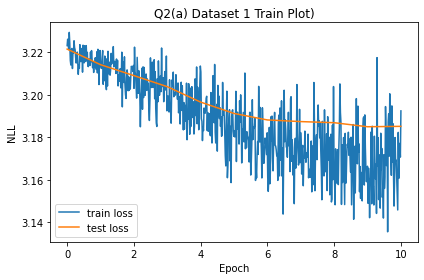

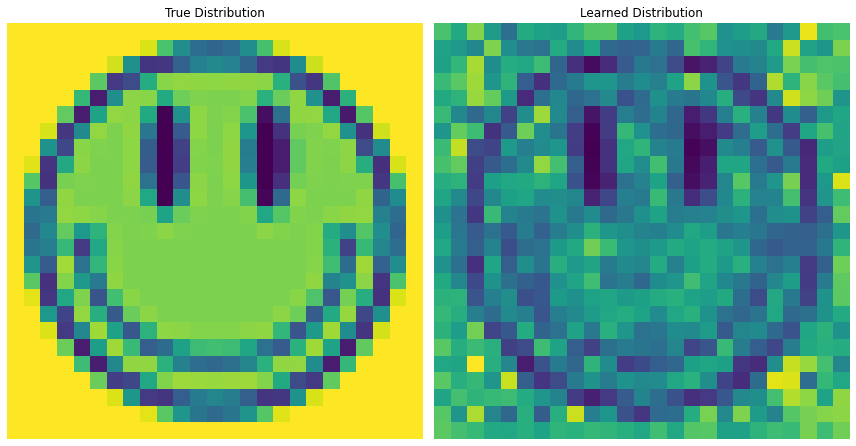

In [11]:
q2_save_results(1, 'a', q2_a)

400 64
64 64
64 400
(64, 400)
(64, 64)
(400, 64)
Final Test Loss: 5.2769


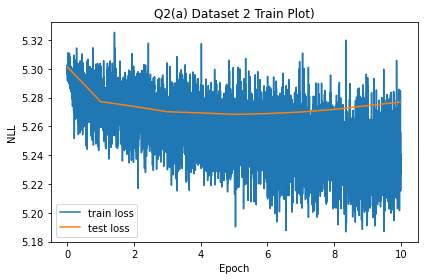

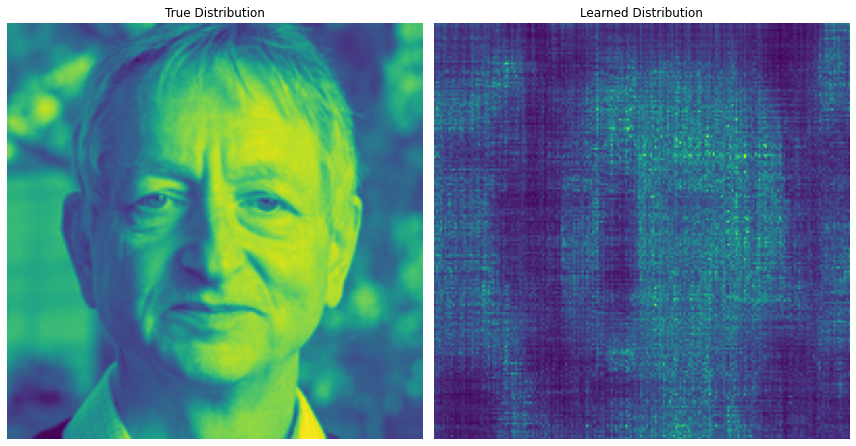

In [12]:
q2_save_results(2, 'a', q2_a)

In [0]:
def q2_b(train_data, test_data, image_shape, dset_id):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  image_shape: (H, W), height and width of the image
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
  """
  # batch channel H W
  train_data = np.transpose(train_data, (0, 3, 1, 2))
  test_data = np.transpose(test_data, (0, 3, 1, 2))

  H, W = image_shape
  model = MADE( (1, H, W), 2, hidden_states=[512, 512]).cuda()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  train_losses, test_losses = train(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))
  samples = model.sample(100)
  samples = np.transpose(samples, (0, 2, 3, 1))
  return train_losses, test_losses, samples

800 512
512 512
512 800
(512, 800)
(512, 512)
(800, 512)
Final Test Loss: 0.0670


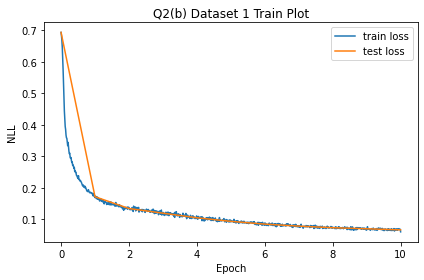

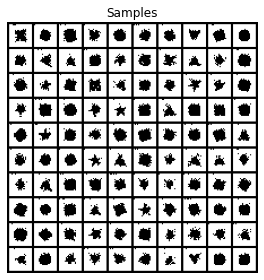

In [20]:
q2_save_results(1, 'b', q2_b)

1568 512
512 512
512 1568
(512, 1568)
(512, 512)
(1568, 512)
Final Test Loss: 0.1297


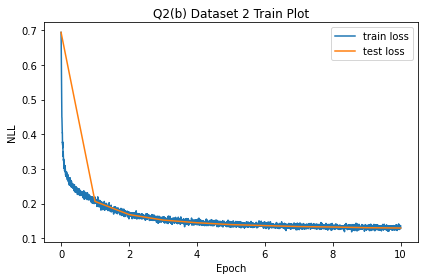

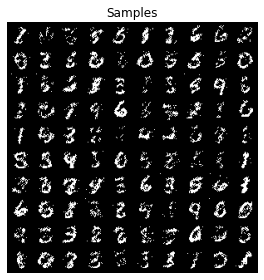

In [21]:
q2_save_results(2, 'b', q2_b)